In [2]:
import math
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

C:\Users\madhu\AppData\Local\Temp\ipykernel_29728\617933152.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stockData = yf.download(stocks, start=start, end=end)['Close']
[*********************100%***********************]  6 of 6 completed


6 6
meanof returns: Ticker
BHP.AX   -0.000368
CBA.AX    0.001567
NAB.AX    0.000592
STO.AX    0.000675
TLS.AX    0.001222
WBC.AX    0.000862
dtype: float64 covariance of returns Ticker    BHP.AX    CBA.AX    NAB.AX    STO.AX    TLS.AX    WBC.AX
Ticker                                                            
BHP.AX  0.000216  0.000022  0.000038  0.000114 -0.000010  0.000047
CBA.AX  0.000022  0.000180  0.000122  0.000063  0.000013  0.000123
NAB.AX  0.000038  0.000122  0.000187  0.000085  0.000006  0.000133
STO.AX  0.000114  0.000063  0.000085  0.000378  0.000019  0.000084
TLS.AX -0.000010  0.000013  0.000006  0.000019  0.000061  0.000011
WBC.AX  0.000047  0.000123  0.000133  0.000084  0.000011  0.000170


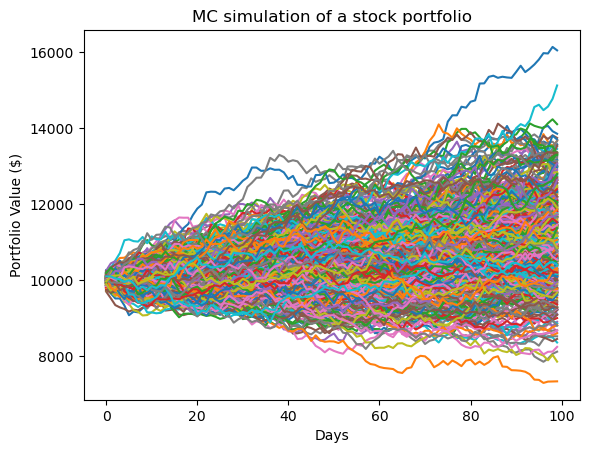

VaR_5 $908.95
CVaR_5 $1418.21


In [48]:
import yfinance as yf
import pandas as pd

def get_data(stocks, start, end):
    stockData = yf.download(stocks, start=start, end=end)['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix


stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock + '.AX' for stock in stockList]
endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=300)

meanReturns, covMatrix = get_data(stocks, startDate, endDate)
print(len(meanReturns),len(covMatrix))
print("meanof returns:",meanReturns,"covariance of returns",covMatrix)
weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)


mc_sims = 400
T = 100

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(weights)))#uncorrelated RV's
    L = np.linalg.cholesky(covMatrix) #Cholesky decomposition to Lower Triangular Matrix
    dailyReturns = meanM + np.inner(L, Z) #Correlated daily returns for individual stocks
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")


portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR_5 ${}'.format(round(VaR,2)))
print('CVaR_5 ${}'.format(round(CVaR,2)))

In [ ]:

S = 101.15         
K = 98.01           
vol = 0.0991        
r = 0.01           
N = 10            
M = 10000           

market_value = 3.86 #market price
T = ((datetime.date(2022,3,17)-datetime.date(2022,1,17)).days+1)/365    #time in years
print(T)

0.1643835616438356


In [45]:
dt=T/N
lnSt=np.log(S)
v=r-0.5*vol**2
vdt=v*dt
voldt=vol*np.sqrt(dt)
Ci=[]
for i in range(M):
    lnSdt=lnSt
    for j in range(N):
        lnSdt=lnSdt+vdt+voldt*np.random.normal()
    Sdt=np.exp(lnSdt)
    payoff_i=max((Sdt-K),0)
    Ci.append(payoff_i* np.exp(-r*T))
sum_option=sum(Ci)
avg_option=sum_option/M
Std_dev=0
for i in range(len(Ci)):
    Std_dev+=(Ci[i]-avg_option)**2
Std_dev/=M-1
Std_dev=np.sqrt(Std_dev)
Std_error=Std_dev/np.sqrt(M)
print("avg.discounted payoff is",avg_option,f"Standard error is -/+{Std_error}")



        

avg.discounted payoff is 3.7521753984319512 Standard error is -/+0.03410678653201568


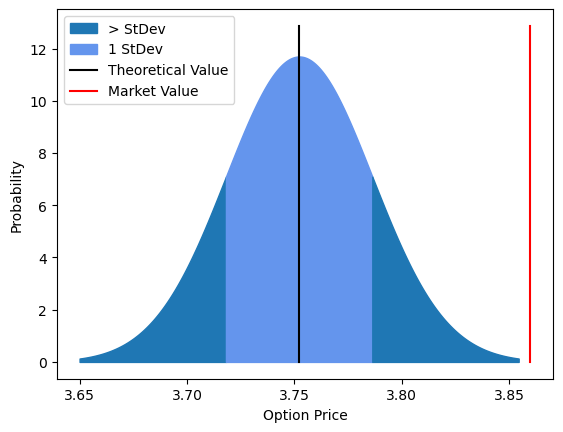

In [46]:
x1 = np.linspace(avg_option-3*Std_error, avg_option-1*Std_error, 100)
x2 = np.linspace(avg_option-1*Std_error, avg_option+1*Std_error, 100)
x3 = np.linspace(avg_option+1*Std_error, avg_option+3*Std_error, 100)

s1 = stats.norm.pdf(x1, avg_option, Std_error)
s2 = stats.norm.pdf(x2, avg_option, Std_error)
s3 = stats.norm.pdf(x3,avg_option, Std_error)

plt.fill_between(x1, s1, color='tab:blue',label='> StDev')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue')

plt.plot([avg_option,avg_option],[0, max(s2)*1.1], 'k',
        label='Theoretical Value')
plt.plot([market_value,market_value],[0, max(s2)*1.1], 'r',
        label='Market Value')

plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()